# ALTEGRAD Challenge Starting Kit

    Authors : Léa BRESSON, Eya KALBOUSSI, Dinh-Phong NGUYEN, Benoît ROBAGLIA

### "Can you predict whether two short texts have the same meaning?"

* The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning.

* The ground truth is a set of labels supplied by human experts. This is inherently subjective, as the true meaning of sentences can not be known with certainty. Human labeling is a 'noisy' process, and different people would probably disagree. As a result, ground truth labels on this dataset should be taken as indications but not 100% accurate, and may include incorrect labeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')

In [2]:
train_filename = 'train.csv'
data = pd.read_csv(train_filename, header=None, names=['row_id', 'text_a_id', 'text_b_id', 'text_a', 'text_b', 'same_meaning'])
test_filename = 'test.csv'
test = pd.read_csv(test_filename, header=None, names=['row_id', 'text_a_id', 'text_b_id', 'text_a', 'text_b'])
data[0:10]

,row_id,text_a_id,text_b_id,text_a,text_b,same_meaning
0,0,199954,384085,What are the some of the best novels?,What are some of the greatest novels of all ti...,0
1,1,128681,237407,What are the pictures that made you look twice?,What are some amazing pictures one has to see ...,0
2,2,170846,240621,Have the ellectoral college members ever voted...,When has the electoral college voted against t...,1
3,3,55110,177468,Did Ravana really have 10 heads?,Why did Ravana have 10 heads?,1
4,4,425513,400256,What's a book that you feel helped you to impr...,What books or magazines should I read to impro...,0
5,5,105990,256943,Is astrology true? Should we believe it or not?,Should you believe in astrology and astrologer...,1
6,6,366314,224793,What are some of the biggest lies that you eve...,What is the biggest lie ever told by any gover...,0
7,7,167249,167582,How can I advertise my YouTube Channel to get ...,How can I get more traffic to my YouTube videos?,0
8,8,344939,281696,Is time travel possible through cosmic strings?,Is time travel already possible on Earth?,1
9,9,107721,138968,What should I do to earn money online?,How can I earn money on internet?,1


## Basic stats

In [3]:
data.dtypes

row_id           int64
text_a_id        int64
text_b_id        int64
text_a          object
text_b          object
same_meaning     int64
dtype: object

In [4]:
data.describe()

,row_id,text_a_id,text_b_id,same_meaning
count,80100.000000,80100.000000,80100.000000,80100.000000
mean,40049.500000,228218.494370,227554.505855,0.648427
std,23123.022618,130598.247917,131066.559216,0.477464
min,0.000000,16.000000,16.000000,0.000000
25%,20024.750000,115915.000000,114350.000000,0.000000
50%,40049.500000,229290.000000,227268.000000,1.000000
75%,60074.250000,341278.000000,340507.000000,1.000000
max,80099.000000,452471.000000,452477.000000,1.000000


In [5]:
data.count()

row_id          80100
text_a_id       80100
text_b_id       80100
text_a          80100
text_b          80100
same_meaning    80100
dtype: int64

In [6]:
def mean_len(x, y):
    mean_a = np.mean([len(a.split()) for a in x])
    mean_b = np.mean([len(b.split()) for b in y])
    mean = pd.Series([mean_a, mean_b])
    mean_len = pd.concat([pd.Series(["A", "B"]), mean], axis=1).rename(columns={0:"Text", 1:"Mean"})
    return mean_len.set_index("Text")

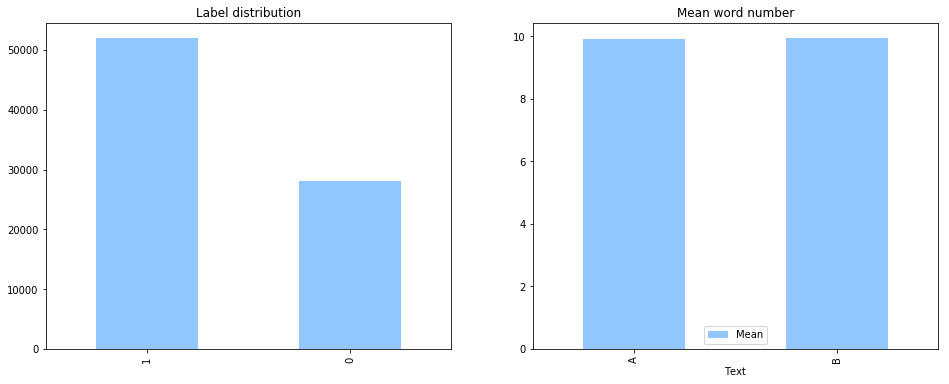

In [7]:
fig, ax = plt.subplots(1, 2)
data.same_meaning.value_counts().plot(ax=ax[0], kind='bar', figsize=(16,6), title="Label distribution")
mean_len(data.text_a, data.text_b).plot(ax=ax[1], kind='bar', title="Mean word number");

# Classical models

In [8]:
from __future__ import print_function
import string
import unicodedata

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.base import BaseEstimator

### Cleaning data (useful for some features)

* Removing punctuation, accents and stopwords
* Option for stemming if needed
* Tokenization

In [9]:
def clean_str(sentence, stem=True):
    english_stopwords = set(
        [stopword for stopword in stopwords.words('english')])
    punctuation = set(string.punctuation)
    punctuation.update(["``", "`", "..."])
    if stem:
        stemmer = SnowballStemmer('english')
        return list((filter(lambda x: x.lower() not in english_stopwords and
                            x.lower() not in punctuation,
                            [stemmer.stem(t.lower())
                             for t in word_tokenize(sentence)
                             if t.isalpha()])))

    return list((filter(lambda x: x.lower() not in english_stopwords and
                        x.lower() not in punctuation,
                        [t.lower() for t in word_tokenize(sentence)
                         if t.isalpha()])))



def strip_accents_unicode(s):
    try:
        s = unicode(s, 'utf-8')
    except NameError:  # unicode is a default on python 3
        pass
    s = unicodedata.normalize('NFD', s)
    s = s.encode('ascii', 'ignore')
    s = s.decode("utf-8")
    return str(s)

In [13]:
Non_cleaned_a = data.text_a
Non_cleaned_b = data.text_b
index = [i for i in range(len(Non_cleaned_a)) if ((len(Non_cleaned_b[i].split()) != 1) and (len(Non_cleaned_a[i].split()) != 1))]
cleaned_a = [Non_cleaned_a[i] for i in index]
cleaned_b = [Non_cleaned_b[i] for i in index]

In [14]:
Non_cleaned_a = test.text_a
Non_cleaned_b = test.text_b
index = [i for i in range(len(Non_cleaned_a)) if ((len(Non_cleaned_b[i].split()) != 1) and (len(Non_cleaned_a[i].split()) != 1))]
cleaned_a_test = [Non_cleaned_a[i] for i in index]
cleaned_b_test = [Non_cleaned_b[i] for i in index]

In [15]:
clean_text_a = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in cleaned_a]
clean_text_b = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in cleaned_b]

clean_test_a = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in cleaned_a_test]
clean_test_b = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in cleaned_b_test]

text_a = [''.join(x) for x in data.text_a]
text_b = [''.join(x) for x in data.text_b]

test_a = [''.join(x) for x in test.text_a]
test_b = [''.join(x) for x in test.text_b]

clean_texts = clean_text_a + clean_text_b
texts = text_a + text_b 

In [16]:
clean_text_a = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in data.text_a]
clean_text_b = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in data.text_b]

clean_test_a = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in test.text_a]
clean_test_b = [' '.join(clean_str(strip_accents_unicode(x), stem = False)) for x in test.text_b]

text_a = [''.join(x) for x in data.text_a]
text_b = [''.join(x) for x in data.text_b]

test_a = [''.join(x) for x in test.text_a]
test_b = [''.join(x) for x in test.text_b]

clean_texts = clean_text_a + clean_text_b + clean_test_a + clean_test_a
texts = text_a + text_b + test_a + test_b

In [17]:
print("\033[1mBefore cleaning: \033[0m" + data.text_a[42])
print("\033[1mAfter cleaning: \033[0m" + clean_text_a[42])

Before cleaning: What has restored your faith in humanity?
After cleaning: restored faith humanity


## Graphs

### Feature engineering

#### Graph-based approach

In [18]:
import os
import time
import itertools
import math
import networkx as nx

In [19]:
def terms_to_graph(lists_of_terms, window_size, overspanning):
    # This function returns a directed, weighted graph from lists of list of terms (the tokens from the pre-processed text)
    # e.g., [['quick','brown','fox'], ['develop', 'remot', 'control'], etc]
    # Edges are weighted based on term co-occurence within a sliding window of fixed size 'w'

    if overspanning:
        terms = [item for sublist in lists_of_terms for item in sublist]
    else:
        idx = 0
        terms = lists_of_terms[idx]

    from_to = {}

    while True:
        w = min(window_size, len(terms))
        # create initial complete graph (first w terms)
        terms_temp = terms[0:w]
        indexes = list(itertools.combinations(range(w), r=2))

        new_edges = []

        for my_tuple in indexes:
            new_edges.append(tuple([terms_temp[i] for i in my_tuple]))
        for new_edge in new_edges:
            if new_edge in from_to:
                from_to[new_edge] += 1
            else:
                from_to[new_edge] = 1

        # then iterate over the remaining terms
        for i in range(w, len(terms)):
            # term to consider
            considered_term = terms[i]
            # all terms within sliding window
            terms_temp = terms[(i - w + 1):(i + 1)]

            # edges to try
            candidate_edges = []
            for p in range(w - 1):
                candidate_edges.append((terms_temp[p], considered_term))

            for try_edge in candidate_edges:

                # if not self-edge
                if try_edge[1] != try_edge[0]:

                    # if edge has already been seen, update its weight
                    if try_edge in from_to:
                        from_to[try_edge] += 1

                    # if edge has never been seen, create it and assign it a unit weight
                    else:
                        from_to[try_edge] = 1

        if overspanning:
            break
        else:
            idx += 1
            if idx == len(lists_of_terms):
                break
            terms = lists_of_terms[idx]
    #create list of tuple 
    edg = []
    for k,v in from_to.items():
        lll = list(k)
        lll.append(v)
        edg.append(tuple(lll) ) 
    # create empty graph
    g = nx.Graph(directed=True)

    # add vertices
    if overspanning:
        g.add_nodes_from(sorted(set(terms)))
    else:
        g.add_nodes_from(sorted(set([item for sublist in lists_of_terms for item in sublist])) )

    # add edges, direction is preserved since the graph is directed
    g.add_weighted_edges_from(edg)

    #set edge and vertice weights
    #for u,v,d in G.edges(data=True):
    #    d 
    #g.es['weight'] = from_to.values()  # based on co-occurence within sliding window
    #g.vs['weight'] = g.strength(weights=from_to.values())  # weighted degree
    #g.nodes()
    return (g)

In [21]:
text_a_stem = data["text_a"].apply(lambda x: clean_str(strip_accents_unicode(x), stem = True) )
text_b_stem = data["text_b"].apply(lambda x: clean_str(strip_accents_unicode(x), stem = True) )
test_a_stem = test["text_a"].apply(lambda x: clean_str(strip_accents_unicode(x), stem = True) )
test_b_stem = test["text_b"].apply(lambda x: clean_str(strip_accents_unicode(x), stem = True) )

In [22]:
g = terms_to_graph(list(text_a_stem) + list(text_b_stem), 3, False)
g_test = terms_to_graph(list(test_a_stem) + list(test_b_stem), 3, False)

In [23]:
nx.info(g)

'Name: \nType: Graph\nNumber of nodes: 11215\nNumber of edges: 146616\nAverage degree:  26.1464'

In [24]:
def intersect(a, b):
    return list(set(a) & set(b))

def context_similarity_distance(s1, s2, g):
    #s1 and s2 are the stemmed tokens
    sim = []
    for word in set(s2):
        for word2 in set(s1):
            c1 = list(g.neighbors(word))
            c2 = list(g.neighbors(word2))
            if len(list(set(c1).union(c2))) != 0:
                sim.append(len(intersect(c1,c2)) / len(list(set(c1).union(c2))))
            else:
                sim.append(0)
    if len(sim) == 0:
        return 0
    else:
        return sum(sim)/len(sim)

In [25]:
csd_train = pd.Series([context_similarity_distance(text_a_stem[i], text_b_stem[i], g) for i in range(len(data))])
csd_test = pd.Series([context_similarity_distance(test_a_stem[i], test_b_stem[i], g_test) for i in range(len(test))])

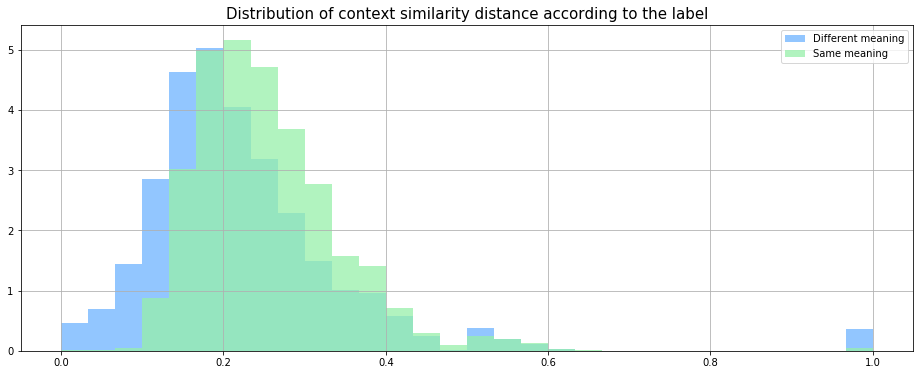

In [26]:
plt.figure(figsize=(16, 6))
csd_train[data["same_meaning"] == 0].hist(bins=30, normed=True, label='Different meaning')
csd_train[data["same_meaning"] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Distribution of context similarity distance according to the label', fontsize=15);

#### TF(-IDF)

* Unigrams and bigrams considered
* L1-norm
* No IDF
* Min frequency considered: 3

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(strip_accents=None, lowercase=True,
            preprocessor=None, tokenizer=None, analyzer='word',
            stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
            ngram_range=(1, 2), max_df=1.0, min_df=3,
            max_features=None, vocabulary=None, binary=False,
            dtype=np.int64, norm='l1', use_idf=False, smooth_idf=True,
            sublinear_tf=False)

In [28]:
vectorizer.fit(texts)
tfidf_a = vectorizer.transform(text_a)
tfidf_b = vectorizer.transform(text_b)

tfidf_a_test = vectorizer.transform(test_a)
tfidf_b_test = vectorizer.transform(test_b)

#### Cosine similarity

* Cosine similarity of the TF matrices for two sentences

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

cossim_train = [cosine_similarity(tfidf_a[i], tfidf_b[i]) for i in range(len(data))]
cossim_train = pd.Series([item for subsublist in cossim_train for sublist in subsublist for item in sublist])

cossim_test = [cosine_similarity(tfidf_a_test[i], tfidf_b_test[i]) for i in range(len(test))]
cossim_test = pd.Series([item for subsublist in cossim_test for sublist in subsublist for item in sublist])

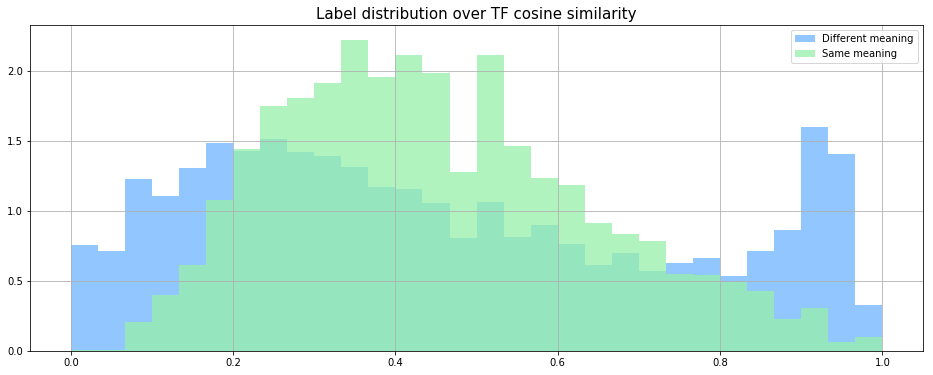

In [30]:
plt.figure(figsize=(16, 6))
cossim_train[data["same_meaning"] == 0].hist(bins=30, normed=True, label='Different meaning')
cossim_train[data["same_meaning"] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over TF cosine similarity', fontsize=15);

#### Levenshtein distance

* Computes the similarity ratio over two sentences according to the Levenshtein distance

In [31]:
from fuzzywuzzy import fuzz
# If not installed: pip install fuzzywuzzy[speedup]

fuzz_train = pd.Series([fuzz.ratio(data.text_a[i], data.text_b[i]) for i in range(len(data))])
fuzz_test = pd.Series([fuzz.ratio(test.text_a[i], test.text_b[i]) for i in range(len(test))])

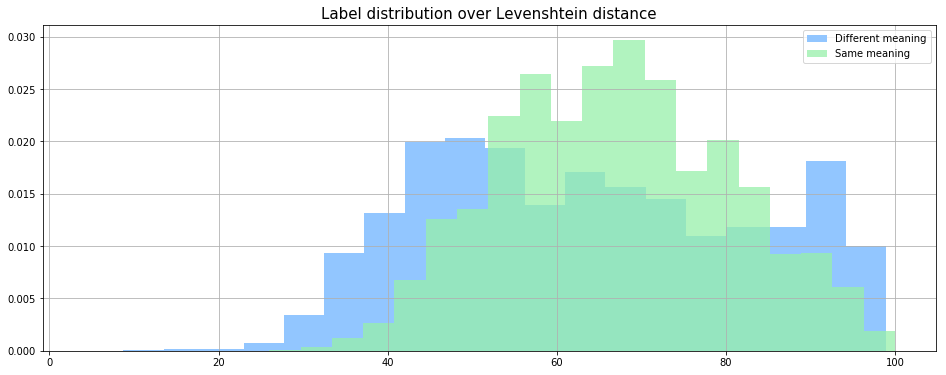

In [32]:
plt.figure(figsize=(16, 6))
fuzz_train[data["same_meaning"] == 0].hist(bins=20, normed=True, label='Different meaning')
fuzz_train[data["same_meaning"] == 1].hist(bins=20, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over Levenshtein distance', fontsize=15);

#### Word match

* Calculates for each text, the number of words it has in common with its counterpart
* Returns the ratio of shared words over total number of unique words in both texts

In [33]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

def word_match(row):
    a_dict = {}
    b_dict = {}
    for word in str(row['text_a']).lower().split():
        if word not in stops:
            a_dict[word] = 1
    for word in str(row['text_b']).lower().split():
        if word not in stops:
            b_dict[word] = 1
    if len(a_dict) == 0 or len(b_dict) == 0:
        return 0
    shared_words_a = [w for w in a_dict.keys() if w in b_dict]
    shared_words_b = [w for w in b_dict.keys() if w in a_dict]
    match = (len(shared_words_a) + len(shared_words_b))/(len(a_dict) + len(b_dict))
    return match

In [34]:
word_match_train = data.apply(word_match, axis=1, raw=True)
word_match_test = test.apply(word_match, axis=1, raw=True)

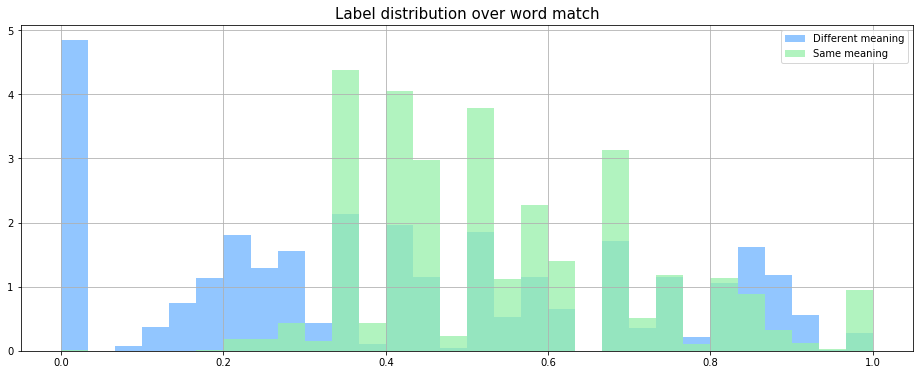

In [35]:
plt.figure(figsize=(16, 6))
word_match_train[data['same_meaning'] == 0].hist(bins=30, normed=True, label='Different meaning')
word_match_train[data['same_meaning'] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over word match', fontsize=15);

#### Part-Of-Speech (POS) Tagging 

* Replaces each word by its grammatical category
* Computes the similarity ratio over two sentences according to the Levenshtein distance

In [36]:
from nltk import pos_tag

tagged_train_a = [pos_tag(word_tokenize(dd)) for dd in text_a]
tagged_train_b = [pos_tag(word_tokenize(dd)) for dd in text_b]
tagged_test_a = [pos_tag(word_tokenize(dd)) for dd in test_a]
tagged_test_b = [pos_tag(word_tokenize(dd)) for dd in test_b]

tag_train_a = np.array([" ".join([tag for word, tag in sent]) for sent in tagged_train_a])
tag_train_b = np.array([" ".join([tag for word, tag in sent]) for sent in tagged_train_b])
tag_test_a = np.array([" ".join([tag for word, tag in sent]) for sent in tagged_test_a])
tag_test_b = np.array([" ".join([tag for word, tag in sent]) for sent in tagged_test_b])

In [37]:
fuzz_tag_train = pd.Series([fuzz.ratio(tag_train_a[i], tag_train_b[i]) for i in range(len(data))])
fuzz_tag_test = pd.Series([fuzz.ratio(tag_test_a[i], tag_test_b[i]) for i in range(len(test))])

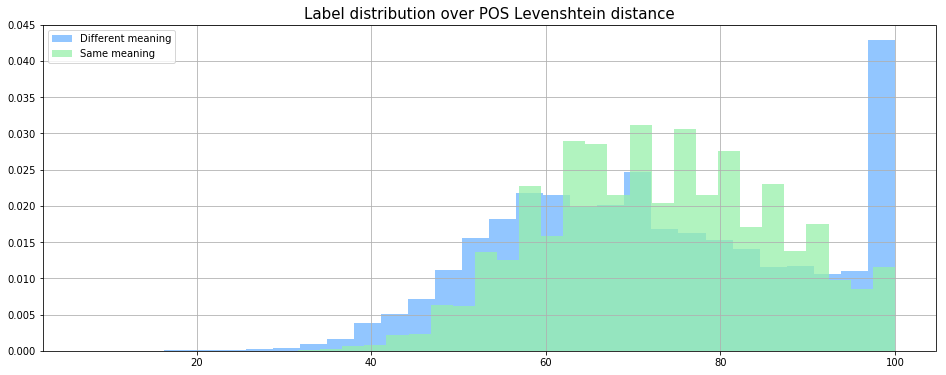

In [38]:
plt.figure(figsize=(16, 6))
fuzz_tag_train[data["same_meaning"] == 0].hist(bins=30, normed=True, label='Different meaning')
fuzz_tag_train[data["same_meaning"] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over POS Levenshtein distance', fontsize=15);

#### Number of questions associated with a given one in the database

* Some questions in text_a have several counterparts in text_b and vice versa
* However, there are some questions which appear in both text_a and text_b, with the same counterparts (see example below)
* Creates a dictionary with all different questions in total as indices
* Counts the number of distinct questions that appear in both text_a and text_b, and that are associated with a given question

In [39]:
all_texts = pd.concat([data[['text_a', 'text_b']], test[['text_a', 'text_b']]], axis=0).reset_index(drop='index')

In [40]:
all_texts.text_b[all_texts.text_a == all_texts.text_a[8]]

8                Is time travel already possible on Earth?
7431                     Is backward time travel possible?
7670     Is it physically possible to travel back in time?
8172     Is it possible to make time machine and do tim...
9854              Is time travel possible in next 5 years?
11149    Is it possible to travel back or forward in time?
13707                     Is time travel to 2010 possible?
14634                  Is time travel possible? If yes how
15214    Is time travel possible then after how long time?
25500    Is time travel possible and if yes can we trav...
28212              Will time travel be possible in future?
30092                       Could time travel be possible?
36488               Will time travel ever become possable?
38882    Could time travel be a real thing? Could it be...
47566    Will time travel be possible in the next 10 ye...
50264               Is time travel theoretically possible?
50432                          Time Travel Is It Possibl

In [41]:
all_texts.text_a[all_texts.text_b == all_texts.text_b[8]]

8          Is time travel possible through cosmic strings?
462      Is it physically possible to travel back in time?
2231                 Is time travel possible? If yes? How?
2338                Will time travel ever become possable?
8974              Is time travel possible in next 5 years?
10783                           Can we time travel anyhow?
11355                          Time Travel Is It Possible?
15382                   Is time traval possible in future?
16901                  Is time travel possible? If yes how
16957      Is it actually possible to travel through time?
19202                     Is time travel to 2010 possible?
28348    Is time travel possible then after how long time?
29977                Do you think time travel is possible?
45636    Can time travel exist somewhere in our univers...
48311    Is it possible to travel back or forward in time?
53610                    Can time travel ever be possible?
58223                         How is time travel possibl

In [42]:
from collections import defaultdict

text_dict = defaultdict(set)
for i in range(all_texts.shape[0]):
        text_dict[all_texts.text_a[i]].add(all_texts.text_b[i])
        text_dict[all_texts.text_b[i]].add(all_texts.text_a[i])

In [43]:
def associated(row):
    return(len(set(text_dict[row['text_a']]).intersection(set(text_dict[row['text_b']]))))

In [44]:
assoc_train = data.apply(associated, axis=1, raw=True)
assoc_test = test.apply(associated, axis=1, raw=True)

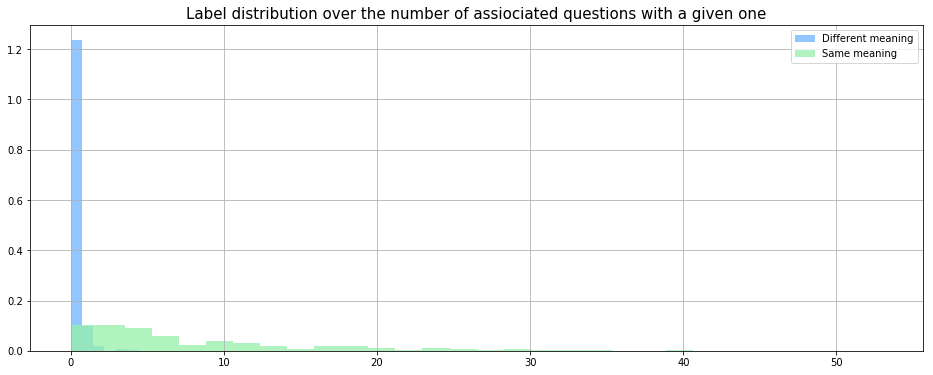

In [45]:
plt.figure(figsize=(16, 6))
assoc_train[data["same_meaning"] == 0].hist(bins=30, normed=True, label='Different meaning')
assoc_train[data["same_meaning"] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over the number of assiociated questions with a given one', fontsize=15);

#### Total number of words of added questions

In [46]:
# Cleaned questions (stopwords removed, etc.)
totalnb_train = pd.Series([len(clean_text_a[i].split()) + len(clean_text_b[i].split()) for i in range(len(clean_text_a))])
totalnb_test = pd.Series([len(clean_test_a[i].split()) + len(clean_test_b[i].split()) for i in range(len(clean_test_a))])

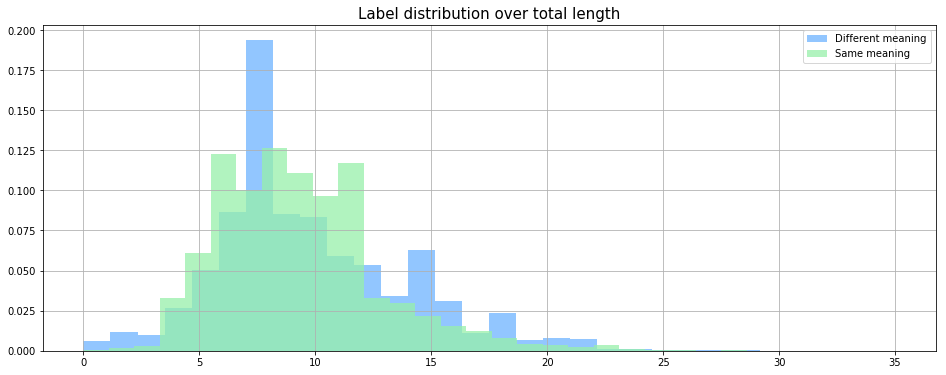

In [47]:
plt.figure(figsize=(16, 6))
totalnb_train[data["same_meaning"] == 0].hist(bins=30, normed=True, label='Different meaning')
totalnb_train[data["same_meaning"] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over total length', fontsize=15);

#### Difference in number of words

In [48]:
# Raw questions
diffnb_train = pd.Series([abs(len(data.text_a[i].split()) - len(data.text_b[i].split())) for i in range(len(data))])
diffnb_test = pd.Series([abs(len(test.text_a[i].split()) - len(test.text_b[i].split())) for i in range(len(test))])

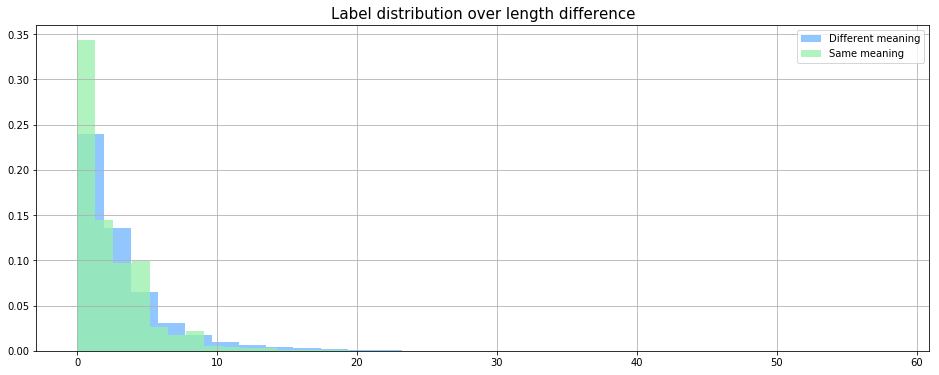

In [49]:
plt.figure(figsize=(16, 6))
diffnb_train[data["same_meaning"] == 0].hist(bins=30, normed=True, label='Different meaning')
diffnb_train[data["same_meaning"] == 1].hist(bins=30, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over length difference', fontsize=15);

#### Sentiment difference

* Calculating the compound sentiment analysis (pos, neu, neg) squared difference

In [50]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

/home/phong/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [51]:
sent_train = pd.Series([np.abs(sid.polarity_scores(data.text_a[i])['compound'] - sid.polarity_scores(data.text_b[i])['compound'])**2 for i in range(len(data))])
sent_test = pd.Series([np.abs(sid.polarity_scores(test.text_a[i])['compound'] - sid.polarity_scores(test.text_b[i])['compound'])**2 for i in range(len(test))])

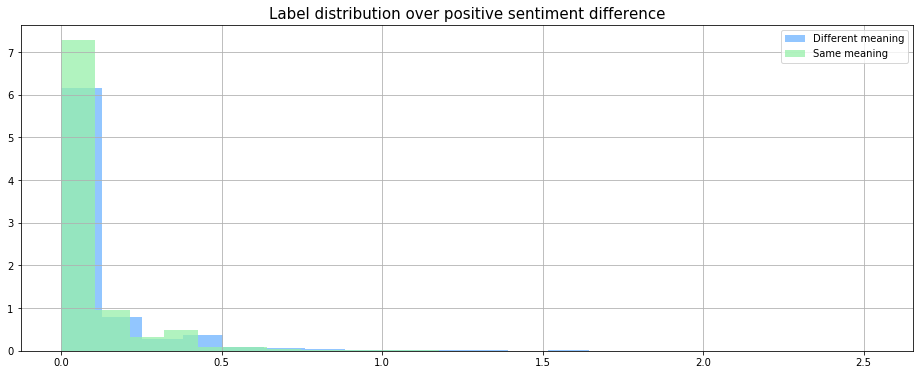

In [52]:
plt.figure(figsize=(16, 6))
sent_train[data["same_meaning"] == 0].hist(bins=20, normed=True, label='Different meaning')
sent_train[data["same_meaning"] == 1].hist(bins=20, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over positive sentiment difference', fontsize=15);

#### First word difference

* Is the first word different?

In [53]:
text_a_first = [x[0] for x in data.text_a.str.split()]
text_b_first = [x[0] for x in data.text_b.str.split()]
test_a_first = [x[0] for x in test.text_a.str.split()]
test_b_first = [x[0] for x in test.text_b.str.split()]

In [54]:
first_train = pd.Series([text_a_first[i] == text_b_first[i] for i in range(len(data))])
first_test = pd.Series([test_a_first[i] == test_b_first[i] for i in range(len(test))])

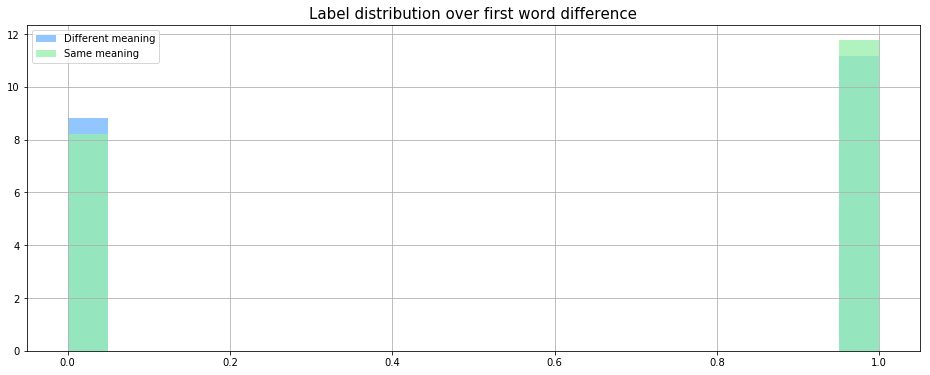

In [55]:
plt.figure(figsize=(16, 6))
first_train[data["same_meaning"] == 0].hist(bins=20, normed=True, label='Different meaning')
first_train[data["same_meaning"] == 1].hist(bins=20, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over first word difference', fontsize=15);

#### Word/Phrase Kernels
* Here we implement a similar feature called the Composition Kernel in Kim et al. (http://www.aclweb.org/anthology/D15-1089)
* Briefly, it is a similarity measure in the 300d word embeddings space of Google's word2vec pretrained vectors, which each sentence represented as the sum of its word vectors

In [108]:
from gensim.models import KeyedVectors
import pickle

In [109]:
model = KeyedVectors.load_word2vec_format('/home/phong/Documents/Data Camp/fake_news/GoogleNews-vectors-negative300.bin', binary=True)

In [110]:
vocab = model.vocab
embeddings = np.array([model.wv[k] for k in vocab.keys()])

In [111]:
keys = vocab.keys()

In [60]:
def phrase_kernel(p1, p2, alpha=1):
    p1_words = p1.split()
    p2_words = p2.split()
    p1_list = []
    p2_list = []
    for i, word in enumerate(p1_words):
        if vocab.get(word) is not None:
            p1_list.append(model.wv[word])
    for i, word in enumerate(p2_words):
        if vocab.get(word) is not None:
            p2_list.append(model.wv[word])
    p1_emb = sum(p1_list)
    p2_emb = sum(p2_list)
    wk = (0.5 * (1. + np.dot(p1_emb, p2_emb) / (np.linalg.norm(p1_emb) * np.linalg.norm(p2_emb)))) ** alpha
    if np.isnan(wk).any():
        wk = 0.5
    return wk

In [61]:
pk_train = pd.Series([phrase_kernel(data.text_a[i], data.text_b[i]) for i in range(len(data))])
pk_test = pd.Series([phrase_kernel(test.text_a[i], test.text_b[i]) for i in range(len(test))])

/home/phong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


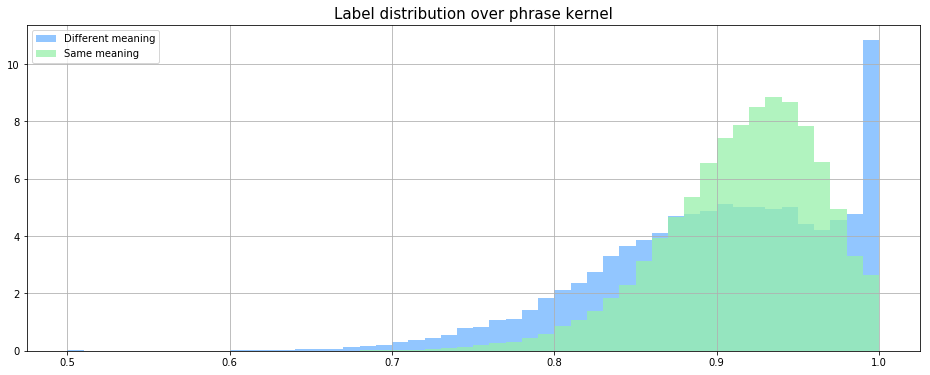

In [62]:
plt.figure(figsize=(16, 6))
pk_train[data["same_meaning"] == 0].hist(bins=50, normed=True, label='Different meaning')
pk_train[data["same_meaning"] == 1].hist(bins=50, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over phrase kernel', fontsize=15);

In [126]:
from scipy.spatial.distance import canberra, dice, minkowski, euclidean, braycurtis
def phrase_kernel(p1, p2, dist="euclidean"):
    p1_words = p1.split()
    p2_words = p2.split()
    p1_list = []
    p2_list = []
    for i, word in enumerate(p1_words):
        if vocab.get(word) is not None:
            p1_list.append(model.wv[word])
    for i, word in enumerate(p2_words):
        if vocab.get(word) is not None:
            p2_list.append(model.wv[word])
    p1_emb = sum(p1_list)
    p2_emb = sum(p2_list)
    if dist == "euclidean":
        wk = euclidean(p1_emb, p2_emb)
    elif dist == "canberra":
        wk = canberra(p1_emb, p2_emb)
    elif dist == "braycurtis":
        wk = braycurtis(p1_emb, p2_emb)
    elif dist == "minkowski":
        wk = minkowski(p1_emb, p2_emb)
    if np.isnan(wk).any():
        wk = 0.5
    return wk

In [113]:
can_train = pd.Series([phrase_kernel(data.text_a[i], data.text_b[i], dist="canberra") for i in range(len(data))])
can_test = pd.Series([phrase_kernel(test.text_a[i], test.text_b[i], dist="canberra") for i in range(len(test))])

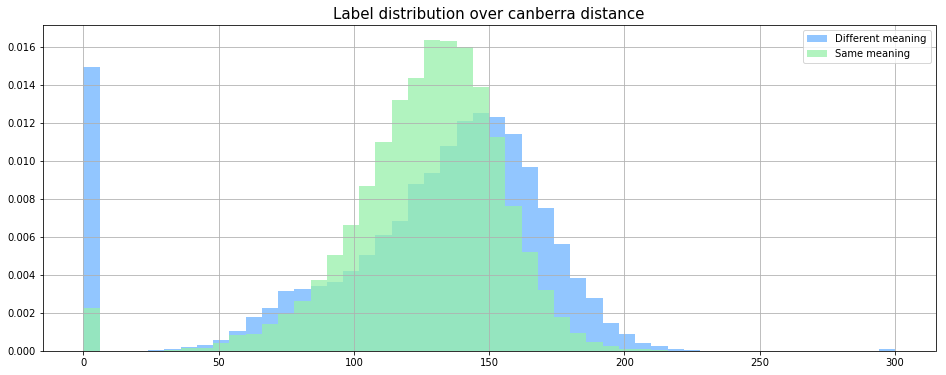

In [115]:
plt.figure(figsize=(16, 6))
can_train[data["same_meaning"] == 0].hist(bins=50, normed=True, label='Different meaning')
can_train[data["same_meaning"] == 1].hist(bins=50, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over canberra distance', fontsize=15);

In [118]:
euc_train = pd.Series([phrase_kernel(data.text_a[i], data.text_b[i], dist="euclidean") for i in range(len(data))])
euc_test = pd.Series([phrase_kernel(test.text_a[i], test.text_b[i], dist="euclidean") for i in range(len(test))])

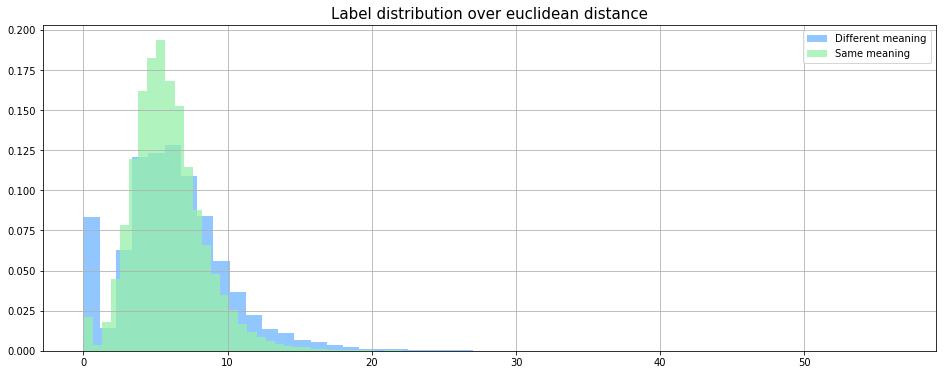

In [119]:
plt.figure(figsize=(16, 6))
euc_train[data["same_meaning"] == 0].hist(bins=50, normed=True, label='Different meaning')
euc_train[data["same_meaning"] == 1].hist(bins=50, normed=True, alpha=0.75, label='Same meaning')
plt.legend()
plt.title('Label distribution over euclidean distance', fontsize=15);

### Testing features

In [63]:
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import itertools
import xgboost as xgb

In [144]:
X = pd.concat([csd_train, cossim_train, fuzz_train, word_match_train, fuzz_tag_train, assoc_train, diffnb_train, totalnb_train, sent_train, first_train, pk_train, can_train, euc_train], axis=1)
X_test = pd.concat([csd_test, cossim_test, fuzz_test, word_match_test, fuzz_tag_test, assoc_test, diffnb_test, totalnb_test, sent_test, first_test, pk_test, can_test, euc_test], axis=1)

In [145]:
y = data.same_meaning
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

#### Batch testing

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

knn_tuned_parameters = [{"n_neighbors": [1, 3, 5, 10, 20, 25, 30, 35, 40, 50, 60, 70, 100]}]
rf_tuned_parameters = [{"n_estimators" : [10, 100, 1000],  "max_depth" : [5, 100, 500], "min_samples_leaf" : [1, 20, 40]}]
MNB_tuned_parameters = [{"alpha" : np.linspace(0.01,1,num=20)}]
logistic_tuned_parameters = [{"C" : np.linspace(0.1,3,num=20)}]

regressors = [AdaBoostClassifier(n_estimators=200, learning_rate=0.01, random_state=42),
              RandomForestClassifier(n_estimators=500, random_state=42),
              GridSearchCV(scoring='neg_log_loss', estimator=RandomForestClassifier(n_jobs=-1), param_grid=rf_tuned_parameters),
              GridSearchCV(scoring='neg_log_loss', estimator=KNeighborsClassifier(), param_grid=knn_tuned_parameters),
              GridSearchCV(scoring='neg_log_loss', estimator=MultinomialNB(), param_grid=MNB_tuned_parameters),
              GridSearchCV(scoring='neg_log_loss', estimator=LogisticRegression(), param_grid=logistic_tuned_parameters)
            ]

def reg_test(regressor,i, verbose=True):
    reg = regressor
    reg.fit(X_train, y_train)
    pred_train = reg.predict_proba(X_train)
    pred_val = reg.predict_proba(X_val)
    score1 = log_loss(y_train, pred_train)
    score2 = log_loss(y_val, pred_val)
    
    if verbose:
        reg_name = str(regressor).split("(")[0] 
        if reg_name == "GridSearchCV" :
            reg_name = name[i]
        print("\033[1mRegressor: %s \033[0m" % reg_name)
        print("Train log-loss:   %0.3f" % score1)
        print("Validation log-loss:   %0.3f" % score2)
    
i=0
name = ["", "", "RF with CV", "kNN with CV", "MNB with CV", "Logistic with CV"]
for r in regressors:
   
    reg_test(r,i)  
    i = i+1

Regressor: AdaBoostClassifier 
Train log-loss:   0.343
Validation log-loss:   0.342
Regressor: RandomForestClassifier 
Train log-loss:   0.049
Validation log-loss:   0.191
Regressor: RF with CV 
Train log-loss:   0.049
Validation log-loss:   0.188
Regressor: kNN with CV 
Train log-loss:   0.260
Validation log-loss:   0.284
Regressor: MNB with CV 
Train log-loss:   0.687
Validation log-loss:   0.671
Regressor: Logistic with CV 
Train log-loss:   0.250
Validation log-loss:   0.245


#### XGBoost

In [146]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['colsample_bytree'] = 0.7
params['eta'] = 0.01
params['max_depth'] = 5

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_val, label=y_val)
d_test = xgb.DMatrix(X_test)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

best_model = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=50, verbose_eval=200)

[0]	train-logloss:0.685769	valid-logloss:0.685797
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[200]	train-logloss:0.256774	valid-logloss:0.260518
[400]	train-logloss:0.198774	valid-logloss:0.205113
[600]	train-logloss:0.185731	valid-logloss:0.193653
[800]	train-logloss:0.180582	valid-logloss:0.190298
[1000]	train-logloss:0.177168	valid-logloss:0.188707
[1200]	train-logloss:0.174294	valid-logloss:0.187853
[1400]	train-logloss:0.171507	valid-logloss:0.187268
[1600]	train-logloss:0.168804	valid-logloss:0.186781
[1800]	train-logloss:0.166332	valid-logloss:0.186464
[2000]	train-logloss:0.163999	valid-logloss:0.186218
[2200]	train-logloss:0.161926	valid-logloss:0.186068
[2400]	train-logloss:0.159997	valid-logloss:0.185886
[2600]	train-logloss:0.157994	valid-logloss:0.18579
[2800]	train-logloss:0.156129	valid-logloss:0.185671
[3000]	train-logloss:0.154212	valid-logloss:0.185543
Stopping.

0)csd, 1)cossim, 2)fuzz, 3)word_match, 4)fuzz_tag, 5)assoc, 6)diffnb, 7)totalnb, 8)sent, 9)first, 10)pk, 11)can, 12)euc


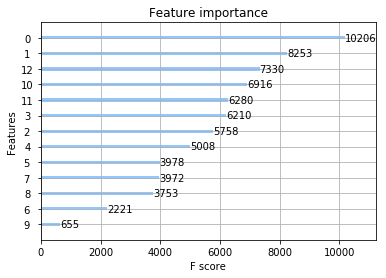

In [147]:
from xgboost import plot_importance
print("0)csd, 1)cossim, 2)fuzz, 3)word_match, 4)fuzz_tag, 5)assoc, 6)diffnb, 7)totalnb, 8)sent, 9)first, 10)pk, 11)can, 12)euc")
plot_importance(best_model);

From what we see, the graph-based feature was the most important of all. We tried removing the least important feature, but our performance on the validation set lowered, so we kept it.

#### Best model: XGBoost

In [148]:
pred_test = best_model.predict(d_test)

submission = pd.DataFrame()
submission['Id'] = test.row_id
submission['Score'] = pred_test
submission[0:10]

,Id,Score
0,0,0.998819
1,1,0.999672
2,2,0.998534
3,3,0.999528
4,4,0.999303
5,5,0.997749
6,6,0.999057
7,7,0.992661
8,8,0.240213
9,9,0.985565


In [142]:
submission.to_csv('submissions/test_xgb10.csv', index=False)

**Public score:** 0.18528

# Simple neural network approach

In [70]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, Callback
from keras.utils import to_categorical

model = Sequential()
 
model.add(Dense(300, activation='relu', input_dim=X.shape[1]))
model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

Using TensorFlow backend.
/home/phong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [71]:
# Fit the model
callbacks = [ModelCheckpoint('simple_weights2.h5', monitor='val_loss', save_best_only=True)]
model.fit(X, y, validation_split=0.20, epochs=50, batch_size=32, callbacks=callbacks)

Train on 64080 samples, validate on 16020 samples
Epoch 1/50
64080/64080 [==============================] - 4s 61us/step - loss: 0.3021 - val_loss: 0.2403
Epoch 2/50
64080/64080 [==============================] - 4s 59us/step - loss: 0.2496 - val_loss: 0.2409
Epoch 3/50
64080/64080 [==============================] - 4s 58us/step - loss: 0.2369 - val_loss: 0.2257
Epoch 4/50
64080/64080 [==============================] - 4s 59us/step - loss: 0.2308 - val_loss: 0.2247
Epoch 5/50
64080/64080 [==============================] - 4s 58us/step - loss: 0.2233 - val_loss: 0.2304
Epoch 6/50
64080/64080 [==============================] - 4s 58us/step - loss: 0.2185 - val_loss: 0.2208
Epoch 7/50
64080/64080 [==============================] - 4s 59us/step - loss: 0.2162 - val_loss: 0.2141
Epoch 8/50
64080/64080 [==============================] - 4s 60us/step - loss: 0.2139 - val_loss: 0.2096
Epoch 9/50
64080/64080 [==============================] - 4s 59us/step - loss: 0.2112 - val_loss: 0.2089
Epoch

#### Making predictions with our best model

In [72]:
model.load_weights('simple_weights2.h5')
y_pred = model.predict(X_test)

In [73]:
submission = pd.concat([test.row_id.rename('Id'), pd.DataFrame(y_pred)[0].rename('Score')], axis=1)
submission[1:10]

,Id,Score
1,1,0.999786
2,2,0.996634
3,3,0.999972
4,4,0.998871
5,5,0.989336
6,6,0.996696
7,7,0.983601
8,8,0.372068
9,9,0.982043


In [74]:
submission.to_csv('submissions/test_nn.csv', index=False)

**Public score:** 0.19751

# Deep learning with word embeddings

In [75]:
import gensim

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten, LSTM, Dropout, Activation, Reshape, BatchNormalization, Lambda
from keras.layers import Conv1D, MaxPooling1D, Embedding, Convolution2D, MaxPooling2D, merge, Bidirectional, concatenate, TimeDistributed
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.layers.merge import Concatenate

In [76]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = BASE_DIR
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

#### Preprocessing our text with pre-trained word embeddings

In [77]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences_a = tokenizer.texts_to_sequences(text_a)
sequences_b = tokenizer.texts_to_sequences(text_b)

word_index = tokenizer.word_index

data_a = pad_sequences(sequences_a, maxlen=MAX_SEQUENCE_LENGTH)
data_b = pad_sequences(sequences_b, maxlen=MAX_SEQUENCE_LENGTH)

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [78]:
embedding_layer_a = Embedding(num_words+1,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)

embedding_layer_b = Embedding(num_words+1,
                    EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False)

In [79]:
sequence_input_a = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
sequence_input_b = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedded_sequences_a = embedding_layer_a(sequence_input_a)
embedded_sequences_b = embedding_layer_b(sequence_input_b)

embedded_sequences = concatenate([embedded_sequences_a, embedded_sequences_b])

#### Defining our layers

In [80]:
features = Input(shape=(X.shape[1],))

x = Conv1D(128, 5, activation='relu')(embedded_sequences)
y = Dense(200, activation="relu")(features)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(10)(x)
x = Flatten()(x)
xy = concatenate([x,y])
x = Dense(128, activation='relu')(xy)
preds = Dense(1, activation='sigmoid')(x)


model = Model(inputs=[sequence_input_a, sequence_input_b, features], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='adam')

#### Training our model and saving the best weights

In [81]:
callbacks = [ModelCheckpoint('weights_all.h5', monitor='val_loss', save_best_only=True)]
model.fit([data_a, data_b, X], data.same_meaning, validation_split=0.15, epochs=5, batch_size=128, callbacks=callbacks)

Train on 68085 samples, validate on 12015 samples
Epoch 1/5
68085/68085 [==============================] - 735s 11ms/step - loss: 0.3140 - val_loss: 0.2976
Epoch 2/5
68085/68085 [==============================] - 737s 11ms/step - loss: 0.2507 - val_loss: 0.2550
Epoch 3/5
68085/68085 [==============================] - 736s 11ms/step - loss: 0.2497 - val_loss: 0.2413
Epoch 4/5
68085/68085 [==============================] - 736s 11ms/step - loss: 0.2409 - val_loss: 0.2647
Epoch 5/5
68085/68085 [==============================] - 736s 11ms/step - loss: 0.2353 - val_loss: 0.2337


#### Making predictions with our best model

In [82]:
seq_test_a = tokenizer.texts_to_sequences(test_a)
seq_test_b = tokenizer.texts_to_sequences(test_b)

data_test_a = pad_sequences(seq_test_a, maxlen=MAX_SEQUENCE_LENGTH)
data_test_b = pad_sequences(seq_test_b, maxlen=MAX_SEQUENCE_LENGTH)

In [83]:
model.load_weights('weights_all.h5')
y_pred = model.predict([data_test_a, data_test_b, X_test])

In [84]:
submission = pd.concat([test.row_id.rename('Id'), pd.DataFrame(y_pred)[0].rename('Score')], axis=1)
submission[1:10]

,Id,Score
1,1,0.999999
2,2,0.999999
3,3,0.999619
4,4,0.999832
5,5,0.997428
6,6,0.998877
7,7,0.989653
8,8,0.102371
9,9,0.974060


In [85]:
submission.to_csv('submissions/test_embeddings_bag6.csv', index=False)

**Public score:** 0.18894